# Librerías
Las librerías utilizadas en este documento son:

In [22]:
pip install fitter


  Created wheel for fitter: filename=fitter-1.4.0-py3-none-any.whl size=25036 sha256=3d035d11fca641d64dbc0061f1ecd1db6ec9a0a318170265b27ca3abb03e8e5f
  Stored in directory: c:\users\jgutierrez\appdata\local\pip\cache\wheels\26\07\d7\685f1a5643d927b18e983ec3cf3b4ff18ec4e1bdbfc1455301
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64231 sha256=c11224d54f9a613bd0e5ea8c656797bc4fc40166b0fe050c0f89e09dcc5bd4d1
  Stored in directory: c:\users\jgutierrez\appdata\local\pip\cache\wheels\91\1a\c5\9dfcc86c5bb27991b4dd27741dd03847dfca83ce975c186ddb
Successfully built fitter easydev


In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from tabulate import tabulate

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

# Varios
# ==============================================================================
import multiprocessing
import random
from itertools import product
from fitter import Fitter, get_common_distributions

In [2]:
# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Lectura y prepración del archivo

In [3]:
# Cargamos el excel de Siniesro consolidado
df=pd.read_excel('BBDD Siniestro - consolidado - definitivo.xlsx')
# Cargamos el excel de encuestas
encuestas=pd.read_excel('Encuestas corregidas 2021-2022.xlsx')

Borramos del dataframe encuestas la columna 'nps100' (que va a ser nuestra columna target) e ID da pesquisa + ID de transacao ya que no aparecen en el dataframe Siniestros

In [4]:
encuestas=encuestas.drop(['nps100','ID da pesquisa', 'ID da transação'],axis=1)

Borramos del dataframe BBDD Siniestro - consolidado - v2.xlsx las columnas que coinciden con el dataframe encuestas ya que no importan para nuestro análisis

In [5]:
df=df.drop(encuestas.columns, axis=1)

La columna [FEC_TERM_SINI] tiene un problema ya que en vez de NAN tiene varios datos que son puntos y esto impide hacer un análisis, por ello sustiuimos esas celdas con puntos por unas celdas vacias

In [6]:
df['FEC_TERM_SINI']= df['FEC_TERM_SINI'].replace(['.'],'')

Borramos las columnas ID para que no afecten a nuestros resultados poruqe están muy correlacionadas

In [7]:
df=df.drop(['ID Transacción','IDPoliza'], axis=1)

In [ ]:
# Información columna nps100 que es nuestra coluna target
Tipos_RESULTADO= list(set(df['nps100']))
print('Tipos nps100:',Tipos_RESULTADO)

In [8]:
# borramos las filas que no tengan resultado en la columna nps100
df=df.dropna(subset="nps100")

In [9]:
df['nps100'].value_counts()

 100.0    10333
-100.0     2754
 0.0       1913
Name: nps100, dtype: int64

In [10]:
npsrestot=10333+2754+1913
print('el porcentaje de nps=100 es:',10333/npsrestot*100)
print('el porcentaje de nps=-100 es:',2754/npsrestot*100)
print('el porcentaje de nps=0 es:',1913/npsrestot*100)

el porcentaje de nps=100 es: 68.88666666666666
el porcentaje de nps=-100 es: 18.360000000000003
el porcentaje de nps=0 es: 12.753333333333334


Encontramos las columnas que mejor sirvan para explicar los resultados de nuestra columna target

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
**INFO: featurewiz can now read feather formatted files. Loading train data...
    Shape of your Data Set loaded: (15000, 108)
    Loaded train data. Shape = (15000, 108)
    Some column names had special characters which were removed...
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
#### Single_Label Multi_Classification problem ####
    loading a random sample of 10000 rows into pandas for EDA
####################################

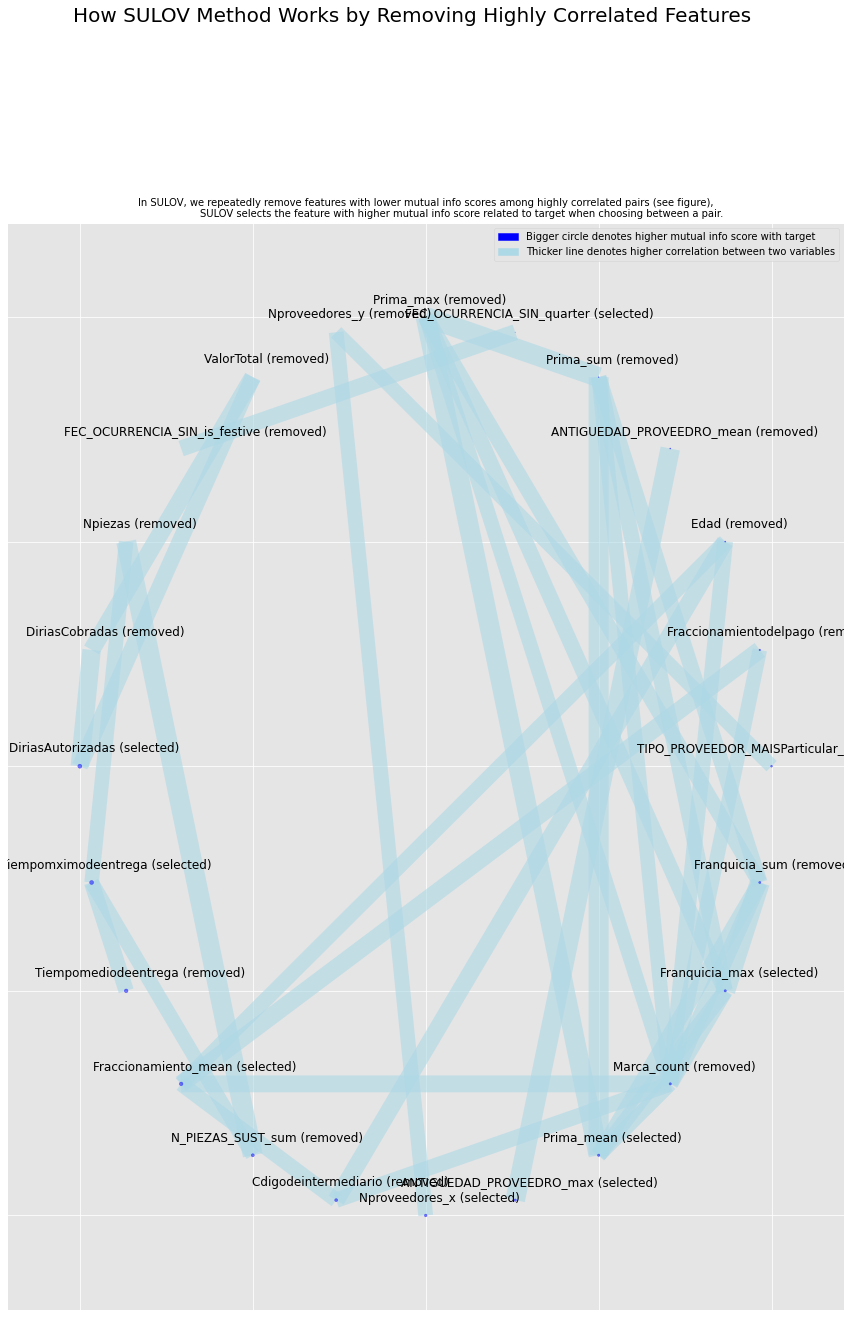

Time taken for SULOV method = 5 seconds
    Adding 22 categorical variables to reduced numeric variables  of 62
Final list of selected vars after SULOV = 84
Readying dataset for Recursive XGBoost by converting all features to numeric...
    there were no mixed data types or object columns that errored. Data is all numeric...
Shape of train data after pruning = (15000, 154)
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Train and Test loaded into Dask dataframes successfully after feature_engg completed
Current number of predictors = 84 
    XGBoost version: 1.6.1
Number of booster rounds = 100
        using 84 variables...
            Time taken for regular XGBoost feature selection = 13 seconds
        using 67 variables...
            Time taken

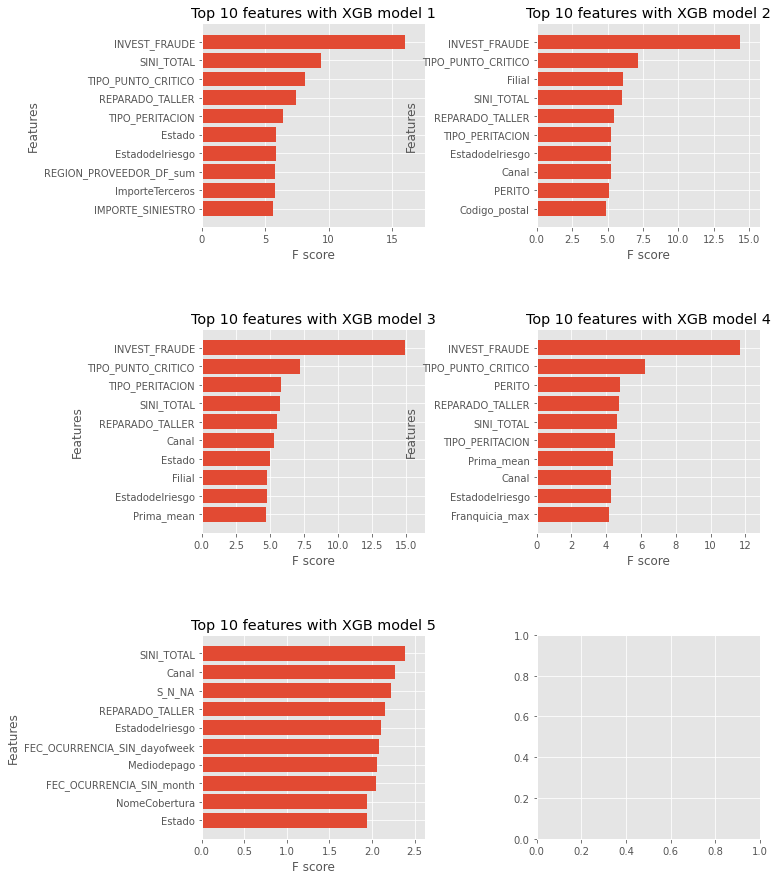

            Total time taken for XGBoost feature selection = 43 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 29 important features:
['INVEST_FRAUDE', 'SINI_TOTAL', 'TIPO_PUNTO_CRITICO', 'REPARADO_TALLER', 'TIPO_PERITACION', 'Estado', 'Estadodelriesgo', 'REGION_PROVEEDOR_DF_sum', 'ImporteTerceros', 'IMPORTE_SINIESTRO', 'Canal', 'REGION_PROVEEDOR_PA_sum', 'REGION_PROVEEDOR_SC_sum', 'Codigo_postal', 'Filial', 'PERITO', 'Prima_mean', 'Franquicia_mean', 'ABR_ESTADO', 'ANTIGUEDAD_PROVEEDRO_max', 'Franquicia_max', 'S_N_NA', 'FEC_OCURRENCIA_SIN_month', 'FEC_OCURRENCIA_SIN_dayofweek', 'Mediodepago', 'NomeCobertura', 'Gnero', 'Grupo', 'DANOS_PROPIOS']

    Time taken for feature selection = 49 seconds
Returning 2 dataframes: dataname and test_data with 29 importan

ValueError: Columns must be same length as key

In [19]:
# import packages 
import pandas as pd 
import numpy as np 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score 
from featurewiz import featurewiz
target = 'nps100'
features, train = featurewiz(df, target, corr_limit=0.7, verbose=2, sep=",",
header=0,test_data="", feature_engg="", category_encoders="")

In [9]:
# Nuestro nuevo dataframe solo con las columnas halladas antes
dfnew=df[['nps100','INVEST_FRAUDE', 'REPARADO_TALLER', 'Importe Terceros', 'REGION_PROVEEDOR_PA_sum', 'IMPORTE_SINIESTRO', 'naci_conductor', 'TIPO_PROVEEDOR_MAIS Particular_sum', 'REGION_PROVEEDOR_BA_sum', 'TIPO_PUNTO_CRITICO', 'Fecha fin póliza', 'REGION_PROVEEDOR_SC_sum', 'Ciudad', 'Antiguedad', 'Codigo_postal', 'REGION_PROVEEDOR_MG_sum', 'REGION_PROVEEDOR_SE_sum', 'Franquicia_mean', 'FEC_HORA_COMUNICACION', 'surveyid', 'REGION_PROVEEDOR_SP_sum', 'Fraccionamiento_mean', 'Diárias Autorizadas', 'ANTIGUEDAD_PROVEEDRO_max', 'CPF', 'Tiempo máximo de entrega', 'S_N_NA', 'Nº proveedores_x', 'Antigüedad del vehículo_max']]

# Análisis exploratorio

In [13]:
dfnew.head(4)

,nps100,INVEST_FRAUDE,REPARADO_TALLER,Importe Terceros,REGION_PROVEEDOR_PA_sum,IMPORTE_SINIESTRO,naci_conductor,TIPO_PROVEEDOR_MAIS Particular_sum,REGION_PROVEEDOR_BA_sum,TIPO_PUNTO_CRITICO,...,surveyid,REGION_PROVEEDOR_SP_sum,Fraccionamiento_mean,Diárias Autorizadas,ANTIGUEDAD_PROVEEDRO_max,CPF,Tiempo máximo de entrega,S_N_NA,Nº proveedores_x,Antigüedad del vehículo_max
1,100.0,N,S,0.00,0.0,0.00,NaN,1.0,0.0,SIN,...,56399439.0,0.0,NaN,NaN,1686.0,NaN,NaN,NaN,NaN,NaN
10,100.0,N,NaN,3532.30,0.0,0.00,1972-02-17,1.0,0.0,SIN,...,67127703.0,0.0,10.0,NaN,4537.0,6.512358e+10,0.60,NaN,1.0,5.0
14,100.0,N,S,1705.85,0.0,0.00,1950-12-20,1.0,0.0,SIN,...,67932817.0,0.0,1.0,NaN,8166.0,1.397062e+10,NaN,S,NaN,2.0
102,100.0,N,S,0.00,0.0,1570.01,NaN,1.0,0.0,SIN,...,58352950.0,0.0,NaN,15.0,2491.0,NaN,2.27,NaN,1.0,NaN


In [14]:
# Tipo de cada columna
# ==============================================================================
# En pandas, el tipo "object" hace referencia a strings
# datos.dtypes
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 1 to 183386
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   nps100                              15000 non-null  float64
 1   INVEST_FRAUDE                       15000 non-null  object 
 2   REPARADO_TALLER                     10097 non-null  object 
 3   Importe Terceros                    15000 non-null  float64
 4   REGION_PROVEEDOR_PA_sum             9806 non-null   float64
 5   IMPORTE_SINIESTRO                   15000 non-null  float64
 6   naci_conductor                      8599 non-null   object 
 7   TIPO_PROVEEDOR_MAIS Particular_sum  9806 non-null   float64
 8   REGION_PROVEEDOR_BA_sum             9806 non-null   float64
 9   TIPO_PUNTO_CRITICO                  15000 non-null  object 
 10  Fecha fin póliza                    8599 non-null   object 
 11  REGION_PROVEEDOR_SC_sum             9806

## Número de observaciones y valores ausentes

In [15]:
# Dimensiones del dataset
# ==============================================================================
dfnew.shape

(15000, 29)

In [16]:
# Número de datos ausentes por variable
# ==============================================================================
dfnew.isna().sum().sort_values()

nps100                                    0
surveyid                                  0
TIPO_PUNTO_CRITICO                        0
IMPORTE_SINIESTRO                         0
FEC_HORA_COMUNICACION                     0
Importe Terceros                          0
INVEST_FRAUDE                             0
REPARADO_TALLER                        4903
TIPO_PROVEEDOR_MAIS Particular_sum     5194
REGION_PROVEEDOR_SE_sum                5194
REGION_PROVEEDOR_SC_sum                5194
REGION_PROVEEDOR_SP_sum                5194
REGION_PROVEEDOR_MG_sum                5194
REGION_PROVEEDOR_PA_sum                5194
REGION_PROVEEDOR_BA_sum                5194
ANTIGUEDAD_PROVEEDRO_max               5195
CPF                                    6401
Fraccionamiento_mean                   6401
Codigo_postal                          6401
Antiguedad                             6401
Ciudad                                 6401
Fecha fin póliza                       6401
naci_conductor                  

In [10]:
#dfnew[['nps100','INVEST_FRAUDE', 'REPARADO_TALLER', 'Importe Terceros', 'REGION_PROVEEDOR_PA_sum', 'IMPORTE_SINIESTRO', 'naci_conductor', 'TIPO_PROVEEDOR_MAIS Particular_sum', 'REGION_PROVEEDOR_BA_sum', 'TIPO_PUNTO_CRITICO', 'Fecha fin póliza', 'REGION_PROVEEDOR_SC_sum', 'Ciudad', 'Antiguedad', 'Codigo_postal', 'REGION_PROVEEDOR_MG_sum', 'REGION_PROVEEDOR_SE_sum', 'Franquicia_mean', 'FEC_HORA_COMUNICACION', 'surveyid', 'REGION_PROVEEDOR_SP_sum', 'Fraccionamiento_mean', 'Diárias Autorizadas', 'ANTIGUEDAD_PROVEEDRO_max', 'CPF', 'Tiempo máximo de entrega', 'S_N_NA', 'Nº proveedores_x', 'Antigüedad del vehículo_max']]=pd.Series([round(val,2)for val in df[['nps100','INVEST_FRAUDE', 'REPARADO_TALLER', 'Importe Terceros', 'REGION_PROVEEDOR_PA_sum', 'IMPORTE_SINIESTRO', 'naci_conductor', 'TIPO_PROVEEDOR_MAIS Particular_sum', 'REGION_PROVEEDOR_BA_sum', 'TIPO_PUNTO_CRITICO', 'Fecha fin póliza', 'REGION_PROVEEDOR_SC_sum', 'Ciudad', 'Antiguedad', 'Codigo_postal', 'REGION_PROVEEDOR_MG_sum', 'REGION_PROVEEDOR_SE_sum', 'Franquicia_mean', 'FEC_HORA_COMUNICACION', 'surveyid', 'REGION_PROVEEDOR_SP_sum', 'Fraccionamiento_mean', 'Diárias Autorizadas', 'ANTIGUEDAD_PROVEEDRO_max', 'CPF', 'Tiempo máximo de entrega', 'S_N_NA', 'Nº proveedores_x', 'Antigüedad del vehículo_max']]])
dfnew['Importe Terceros'] = list(np.around(np.array(dfnew['Importe Terceros']),2))
dfnew['REGION_PROVEEDOR_PA_sum'] = list(np.around(np.array(dfnew['REGION_PROVEEDOR_PA_sum']),2))
dfnew['IMPORTE_SINIESTRO'] = list(np.around(np.array(dfnew['IMPORTE_SINIESTRO']),2))
dfnew['TIPO_PROVEEDOR_MAIS Particular_sum'] = list(np.around(np.array(dfnew['TIPO_PROVEEDOR_MAIS Particular_sum']),2))
dfnew['REGION_PROVEEDOR_BA_sum'] = list(np.around(np.array(dfnew['REGION_PROVEEDOR_BA_sum']),2))
dfnew['REGION_PROVEEDOR_SC_sum'] = list(np.around(np.array(dfnew['REGION_PROVEEDOR_SC_sum']),2))
dfnew['Antiguedad'] = list(np.around(np.array(dfnew['Antiguedad']),2))
dfnew['Codigo_postal'] = list(np.around(np.array(dfnew['Codigo_postal']),2))
dfnew['Antiguedad'] = list(np.around(np.array(dfnew['Antiguedad']),2))
dfnew['REGION_PROVEEDOR_MG_sum'] = list(np.around(np.array(dfnew['REGION_PROVEEDOR_MG_sum']),2))
dfnew['Fraccionamiento_mean'] = list(np.around(np.array(dfnew['Fraccionamiento_mean']),2))
dfnew['Diárias Autorizadas'] = list(np.around(np.array(dfnew['Diárias Autorizadas']),2))
dfnew['ANTIGUEDAD_PROVEEDRO_max'] = list(np.around(np.array(dfnew['ANTIGUEDAD_PROVEEDRO_max']),2))
dfnew['CPF'] = list(np.around(np.array(dfnew['CPF']),2))
dfnew['Tiempo máximo de entrega'] = list(np.around(np.array(dfnew['Tiempo máximo de entrega']),2))
dfnew['Nº proveedores_x'] = list(np.around(np.array(dfnew['Nº proveedores_x']),2))
dfnew['Antigüedad del vehículo_max'] = list(np.around(np.array(dfnew['Antigüedad del vehículo_max']),2))

In [11]:
# Las columnas con Nans las sustituimos por ceros
dfnew = dfnew.fillna(0)

## Variable respuesta

LinAlgError: singular matrix

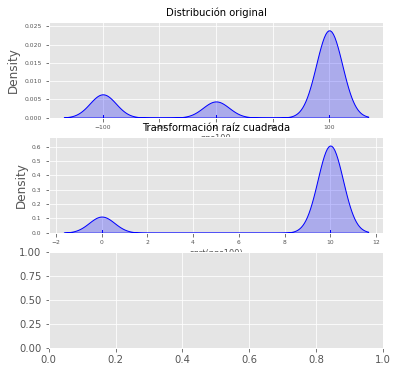

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
sns.distplot(
    dfnew.nps100,
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('nps100', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.distplot(
    np.sqrt(dfnew.nps100),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(nps100)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.distplot(
    np.log(dfnew.nps100),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(nps100)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

In [24]:
distribuciones = ['cauchy', 'chi2', 'expon',  'exponpow', 'gamma',
                  'norm', 'powerlaw', 'beta', 'logistic']

fitter = Fitter(dfnew.nps100, distributions=distribuciones)
fitter.fit()
fitter.summary(Nbest=10, plot=False)

,sumsquare_error,aic,bic,kl_div
beta,0.103424,1296.126501,-178232.386600,inf
powerlaw,0.123469,1165.208704,-175584.733123,inf
chi2,0.125020,3651.046363,-175397.456778,inf
gamma,0.125050,4884.085734,-175393.858059,inf
exponpow,0.125432,1616.327061,-175348.150430,inf
logistic,0.128624,1193.837527,-174980.784304,inf
norm,0.129007,1155.930583,-174936.174341,inf
expon,0.129807,1139.694874,-174843.419191,inf
cauchy,0.131128,7903.489841,-174691.599319,inf


## Variables numéricas

In [26]:
# Variables numéricas
# ==============================================================================
dfnew.select_dtypes(include=['float64', 'int']).describe()

,nps100,Importe Terceros,REGION_PROVEEDOR_PA_sum,IMPORTE_SINIESTRO,TIPO_PROVEEDOR_MAIS Particular_sum,REGION_PROVEEDOR_BA_sum,REGION_PROVEEDOR_SC_sum,Antiguedad,Codigo_postal,REGION_PROVEEDOR_MG_sum,...,Franquicia_mean,surveyid,REGION_PROVEEDOR_SP_sum,Fraccionamiento_mean,Diárias Autorizadas,ANTIGUEDAD_PROVEEDRO_max,CPF,Tiempo máximo de entrega,Nº proveedores_x,Antigüedad del vehículo_max
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,...,15000.000000,1.500000e+04,15000.000000,15000.00000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.0000
mean,50.526667,2592.473189,0.012933,13646.376025,0.522933,0.043733,0.038800,1.200000,2.730559e+07,0.069533,...,1355.401867,6.443486e+07,0.196267,4.23840,3.834867,1411.072800,2.277056e+10,2.106879,0.553733,2.2986
std,78.562931,7727.530667,0.128972,26695.699434,0.656381,0.238798,0.237132,2.546612,3.240593e+07,0.308823,...,1763.881019,5.132884e+06,0.485690,4.45865,8.256287,1630.247777,3.566213e+11,3.930512,0.613355,3.5704
min,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,5.471100e+07,0.000000,0.00000,0.000000,-2903.000000,0.000000e+00,0.000000,0.000000,-1.0000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,6.029423e+07,0.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0000
50%,100.000000,0.000000,0.000000,3676.730000,0.000000,0.000000,0.000000,0.000000,1.257000e+07,0.000000,...,0.000000,6.437773e+07,0.000000,1.00000,0.000000,1016.000000,3.063359e+09,0.000000,0.000000,0.0000
75%,100.000000,2296.092500,0.000000,13248.345000,1.000000,0.000000,0.000000,1.000000,5.703676e+07,0.000000,...,2185.250000,6.869097e+07,0.000000,10.00000,0.000000,2221.000000,2.980495e+10,2.460000,1.000000,4.0000
max,100.000000,282464.770000,4.000000,584610.000000,4.000000,3.000000,4.000000,16.000000,9.996500e+07,4.000000,...,20649.000000,7.340382e+07,4.000000,18.00000,84.000000,9221.000000,3.052001e+13,40.000000,3.000000,25.0000


IndexError: index 9 is out of bounds for axis 0 with size 9

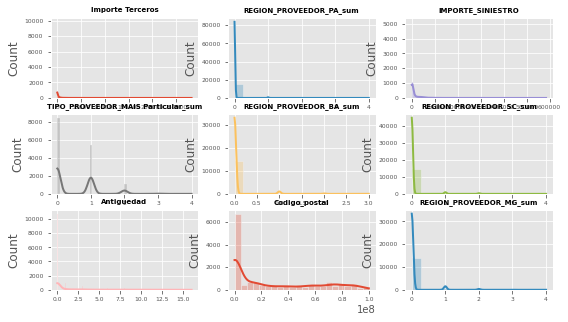

In [27]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_numeric = dfnew.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('nps100')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = dfnew,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

IndexError: index 9 is out of bounds for axis 0 with size 9

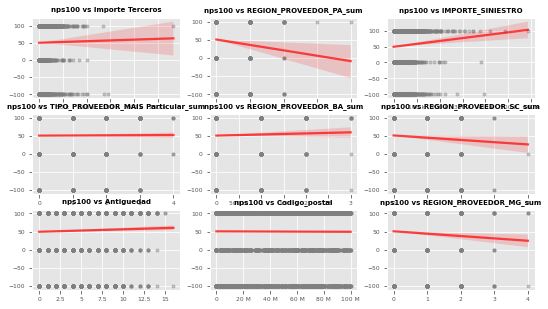

In [29]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_numeric = dfnew.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('nps100')

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x           = dfnew[colum],
        y           = dfnew['nps100'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"nps100 vs {colum}", fontsize = 7, fontweight = "bold")
    #axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
for i in [8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con precio', fontsize = 10, fontweight = "bold");

## Correlación variables numéricas

In [30]:
# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = dfnew.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
305,Fraccionamiento_mean,Franquicia_mean,0.668301,0.668301
245,Franquicia_mean,Fraccionamiento_mean,0.668301,0.668301
182,Codigo_postal,Fraccionamiento_mean,0.604258,0.604258
302,Fraccionamiento_mean,Codigo_postal,0.604258,0.604258
403,Nº proveedores_x,TIPO_PROVEEDOR_MAIS Particular_sum,0.563138,0.563138
103,TIPO_PROVEEDOR_MAIS Particular_sum,Nº proveedores_x,0.563138,0.563138
434,Antigüedad del vehículo_max,Fraccionamiento_mean,0.552521,0.552521
314,Fraccionamiento_mean,Antigüedad del vehículo_max,0.552521,0.552521
397,Tiempo máximo de entrega,Nº proveedores_x,0.530933,0.530933
417,Nº proveedores_x,Tiempo máximo de entrega,0.530933,0.530933


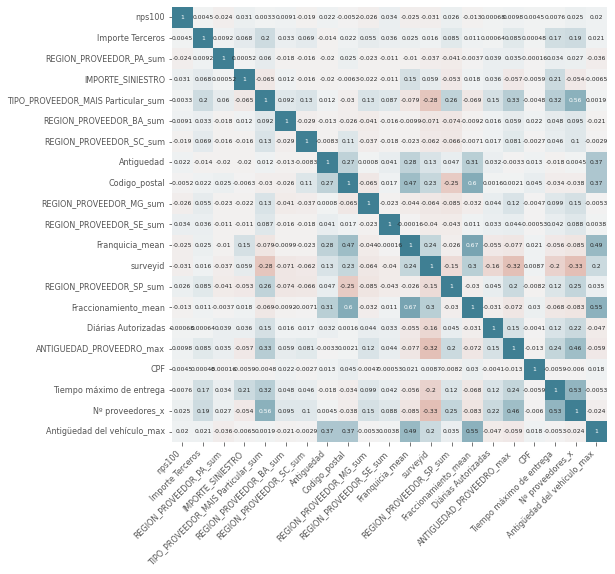

In [31]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

## Variables cualitativas

In [32]:
# Variables cualitativas (tipo object)
# ==============================================================================
dfnew.select_dtypes(include=['object']).describe()

,INVEST_FRAUDE,REPARADO_TALLER,naci_conductor,TIPO_PUNTO_CRITICO,Fecha fin póliza,Ciudad,FEC_HORA_COMUNICACION,S_N_NA
count,15000,15000,15000,15000,15000,15000,15000,15000
unique,2,3,6802,3,1095,1488,598,3
top,N,S,0,SIN,0,0,2022-01-03,0
freq,14929,7989,6401,9285,6401,6401,66,8871


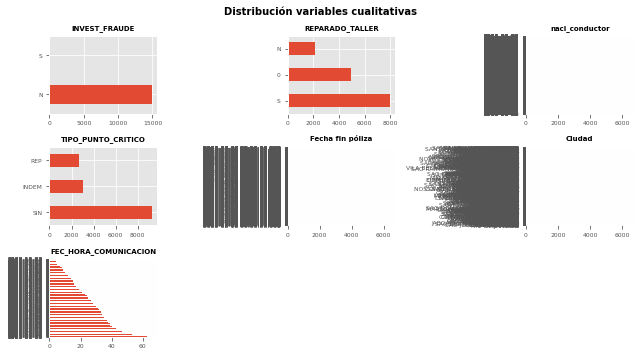

In [34]:
# Gráfico para cada variable cualitativa
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_object = dfnew.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    dfnew[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
for i in [7, 8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize = 10, fontweight = "bold");

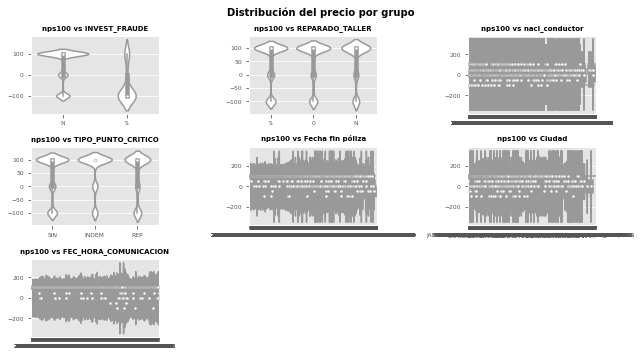

In [35]:
# Gráfico relación entre el nps100 y cada cada variables cualitativas
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_object = dfnew.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    sns.violinplot(
        x     = colum,
        y     = 'nps100',
        data  = dfnew,
        color = "white",
        ax    = axes[i]
    )
    axes[i].set_title(f"nps100 vs {colum}", fontsize = 7, fontweight = "bold")
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
for i in [7, 8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución del precio por grupo', fontsize = 10, fontweight = "bold");

# División train y test

In [12]:
# Cambiamos los datos a category codes para poder hacer nuestros modelos
dfnew['TIPO_PUNTO_CRITICO']=dfnew['TIPO_PUNTO_CRITICO'].astype('category').cat.codes
#dfnew['FEC_TERM_SINI']=dfnew['FEC_TERM_SINI'].astype('category').cat.codes
#dfnew['Fecha inicio de póliza']=dfnew['Fecha inicio de póliza'].astype('category').cat.codes
#dfnew['Fecha fin póliza']=dfnew['Fecha fin póliza'].astype('category').cat.codes
#dfnew['FEC_APER_SINI']=dfnew['FEC_APER_SINI'].astype('category').cat.codes
#df['Data de fechamento do sinistro']=df['Data de fechamento do sinistro'].astype('category').cat.codes
dfnew['FEC_HORA_COMUNICACION']=dfnew['FEC_HORA_COMUNICACION'].astype('category').cat.codes
#dfnew['Nome Cobertura']=dfnew['Nome Cobertura'].astype('category').cat.codes
#dfnew['Descrição Locadora']=dfnew['Descrição Locadora'].astype('category').cat.codes
#dfnew['Filial']=dfnew['Filial'].astype('category').cat.codes
#dfnew['Grupo']=dfnew['Grupo'].astype('category').cat.codes
#dfnew['Fecha_extracción']=dfnew['Fecha_extracción'].astype('category').cat.codes
#dfnew['Género']=dfnew['Género'].astype('category').cat.codes
dfnew['naci_conductor']=dfnew['naci_conductor'].astype('category').cat.codes
#dfnew['Estado']=dfnew['Estado'].astype('category').cat.codes
dfnew['Ciudad']=dfnew['Ciudad'].astype('category').cat.codes
#dfnew['Canal']=dfnew['Canal'].astype('category').cat.codes
#dfnew['Estado del riesgo']=dfnew['Estado del riesgo'].astype('category').cat.codes
dfnew['S_N_NA']=dfnew['S_N_NA'].astype('category').cat.codes
#dfnew['Medio de pago']=dfnew['Medio de pago'].astype('category').cat.codes
#dfnew['ABR_ESTADO']=dfnew['ABR_ESTADO'].astype('category').cat.codes
#dfnew['NOM_PROV']=dfnew['NOM_PROV'].astype('category').cat.codes
#dfnew['PERITO']=dfnew['PERITO'].astype('category').cat.codes
#dfnew['TIPO_PERITACION']=dfnew['TIPO_PERITACION'].astype('category').cat.codes
dfnew['INVEST_FRAUDE']=dfnew['INVEST_FRAUDE'].astype('category').cat.codes
#dfnew['FRAUDE']=dfnew['FRAUDE'].astype('category').cat.codes
#dfnew['TIP_CULPA']=dfnew['TIP_CULPA'].astype('category').cat.codes
dfnew['REPARADO_TALLER']=dfnew['REPARADO_TALLER'].astype('category').cat.codes
#dfnew['DANOS_PROPIOS']=dfnew['DANOS_PROPIOS'].astype('category').cat.codes
#dfnew['DANOS_TERCEROS']=dfnew['DANOS_TERCEROS'].astype('category').cat.codes
#dfnew['SINI_TOTAL']=dfnew['SINI_TOTAL'].astype('category').cat.codes
#dfnew['FEC_OCURRENCIA_SIN']=dfnew['FEC_OCURRENCIA_SIN'].astype('category').cat.codes
dfnew['Franquicia_mean']=dfnew['Franquicia_mean'].astype('category').cat.codes
#dfnew['Franquicia_max']=dfnew['Franquicia_max'].astype('category').cat.codes
#dfnew['Franquicia_sum']=dfnew['Franquicia_sum'].astype('category').cat.codes
#dfnew['Fraccionamiento del pago']=dfnew['Fraccionamiento del pago'].astype('category').cat.codes
dfnew['REGION_PROVEEDOR_SE_sum']=dfnew['REGION_PROVEEDOR_SE_sum'].astype('category').cat.codes
#dfnew['Edad']=dfnew['Edad'].astype('category').cat.codes
dfnew['Fecha fin póliza']=dfnew['Fecha fin póliza'].astype('category').cat.codes

In [13]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        dfnew.drop('nps100', axis = 'columns'),
                                        dfnew['nps100'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [83]:
print("Partición de entrenamento")
print("-----------------------")
print(y_train.describe())

Partición de entrenamento
-----------------------
count    12000.000000
mean        50.241667
std         78.774734
min       -100.000000
25%          0.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: nps100, dtype: float64


In [84]:
print("Partición de test")
print("-----------------------")
print(y_test.describe())

Partición de test
-----------------------
count    3000.000000
mean       51.666667
std        77.712517
min      -100.000000
25%         0.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: nps100, dtype: float64


# Preprocesado

In [14]:
# Selección de las variables por típo
# ==============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

# Se estandarizan las columnas numéricas y se hace one-hot-encoding de las 
# columnas cualitativas. Para mantener las columnas a las que no se les aplica 
# ninguna transformación se tiene que indicar remainder='passthrough'.
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')

In [86]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 45043 to 112409
Data columns (total 28 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   INVEST_FRAUDE                       12000 non-null  int8   
 1   REPARADO_TALLER                     12000 non-null  int8   
 2   Importe Terceros                    12000 non-null  float64
 3   REGION_PROVEEDOR_PA_sum             12000 non-null  float64
 4   IMPORTE_SINIESTRO                   12000 non-null  float64
 5   naci_conductor                      12000 non-null  int16  
 6   TIPO_PROVEEDOR_MAIS Particular_sum  12000 non-null  float64
 7   REGION_PROVEEDOR_BA_sum             12000 non-null  float64
 8   TIPO_PUNTO_CRITICO                  12000 non-null  int8   
 9   Fecha fin póliza                    12000 non-null  int16  
 10  REGION_PROVEEDOR_SC_sum             12000 non-null  float64
 11  Ciudad                              

In [15]:
# Selección de las variables por típo
# ==============================================================================
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                        ]
                      )


# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[
                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))
                            ]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

In [16]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [ ]:
# Convertir el output en dataframe y añadir el nombre de las columnas
# ==============================================================================

encoded_cat = preprocessor.named_transformers_['cat']['onehot']\
              .get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
datos_train_prep = preprocessor.transform(X_train)
datos_train_prep = pd.DataFrame(datos_train_prep, columns=labels)
datos_train_prep.info()

# Crear un modelo

## Entrenamiento

In [17]:
from sklearn.linear_model import Ridge

# Preprocesado
# ==============================================================================

# Identificación de columnas numéricas y categóricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Pipeline
# ==============================================================================

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', Ridge())])

# Train
# ==============================================================================
# Se asigna el resultado a _ para que no se imprima por pantalla
_ = pipe.fit(X=X_train, y=y_train)

## Validación

In [19]:
# Validación cruzada
# ==============================================================================
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas validación cruzada: [-78.45407174 -77.28896328 -77.7362576  -77.51476868 -76.915126  ]
Média métricas de validación cruzada: -77.58183745909882


In [95]:
# Validación cruzada repetida
# ==============================================================================
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=123)
cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = cv
             )

print(f"Métricas de validación cruzada: {cv_scores}")
print("")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas de validación cruzada: [-77.3315323  -77.80270132 -78.40766318 -75.64928168 -79.28905325
 -77.95734134 -78.47587064 -75.41935569 -78.40729215 -77.95690697
 -76.7946545  -77.99608433 -77.56995018 -79.76698919 -76.24448137
 -76.99698247 -78.12307272 -77.1615974  -78.33845562 -77.63606934
 -77.22282707 -78.99955865 -77.06293278 -77.87206997 -77.00580134]

Média métricas de validación cruzada: -77.65954101862042


In [96]:
# Validación cruzada repetida con múltiples métricas
# ==============================================================================
from sklearn.model_selection import cross_validate

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=123)
cv_scores = cross_validate(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2', 'neg_root_mean_squared_error'),
                cv        = cv,
                return_train_score = True
            )

# Se convierte el diccionario a dataframe para facilitar la visualización
cv_scores = pd.DataFrame(cv_scores)
cv_scores

,fit_time,score_time,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
0,0.032982,0.016989,0.030255,0.043862,-77.944920,-76.838052
1,0.028985,0.017013,0.034522,0.041167,-77.524285,-77.069567
2,0.019992,0.008995,0.015902,0.039817,-77.633321,-77.436021
3,0.030273,0.005008,0.015110,0.039519,-78.137262,-77.215106
4,0.029595,0.013385,0.025021,0.046054,-76.885208,-77.368630
5,0.024989,0.010988,0.039835,0.038570,-78.067356,-76.776587
6,0.024991,0.007931,0.035277,0.041422,-77.337027,-77.138579
7,0.025455,0.009996,0.021606,0.038468,-77.908267,-77.241623
8,0.022987,0.008999,0.027723,0.044432,-77.698185,-76.982210
9,0.024988,0.009992,0.035548,0.041132,-77.450787,-77.088083


Text(0.5, 0.98, 'Distribución error de validación cruzada')

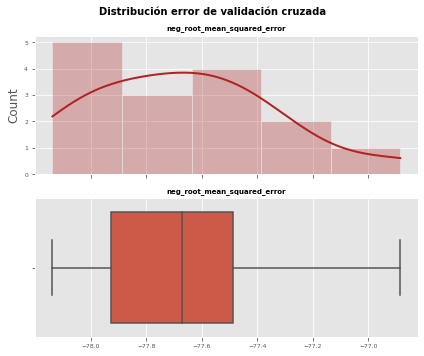

In [97]:
# Distribución del error de validación cruzada
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), sharex=True)

sns.histplot(
    data    = cv_scores['test_neg_root_mean_squared_error'],
    stat    = "count",
    kde     = True,
    line_kws= {'linewidth': 2},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[0]
)

axes[0].set_title('neg_root_mean_squared_error', fontsize = 7, fontweight = "bold")
axes[0].tick_params(labelsize = 6)
axes[0].set_xlabel("")
    
sns.boxplot(
    cv_scores['test_neg_root_mean_squared_error'],
    ax      = axes[1]
)
axes[1].set_title('neg_root_mean_squared_error', fontsize = 7, fontweight = "bold")
axes[1].tick_params(labelsize = 6)
axes[1].set_xlabel("")


fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución error de validación cruzada', fontsize = 10,
             fontweight = "bold")

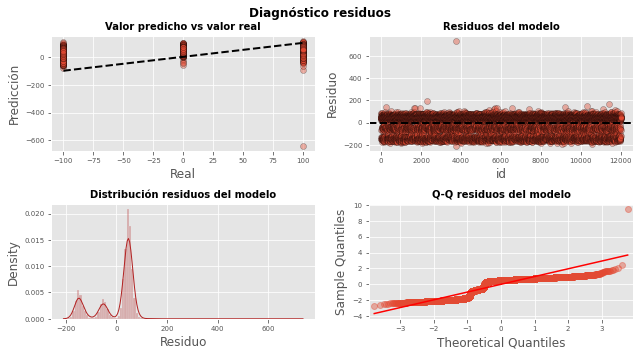

In [98]:
# Diagnóstico errores (residuos) de las predicciones de validación cruzada
# ==============================================================================
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
import statsmodels.api as sm

# Validación cruzada
# ==============================================================================
cv = KFold(n_splits=5, random_state=123, shuffle=True)
cv_prediccones = cross_val_predict(
                    estimator = pipe,
                    X         = X_train,
                    y         = y_train,
                    cv        = cv
                  )

# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 5))

axes[0, 0].scatter(y_train, cv_prediccones, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), y_train - cv_prediccones,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = y_train - cv_prediccones,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    y_train - cv_prediccones,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

In [99]:
# Validación cruzada repetida paralelizada (multicore)
# ==============================================================================
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = cv,
                n_jobs    = -1 # todos los cores disponibles
             )

print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Média métricas de validación cruzada: -77.62117219957871


## Hiperparámetros (tuning)

## Grid search

In [19]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.linear_model import Ridge

# Pipe: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', Ridge())])

# Grid de hiperparámetros
# ==============================================================================
param_grid = {'modelo__alpha': np.logspace(-5, 3, 10)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = pipe,
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 5), 
        verbose    = 0,
        return_train_score = True
       )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = X_train, y = y_train)

In [101]:
# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)

,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
6,2.154435,-77.682781,1.297319,-77.142637,0.267010
5,0.278256,-77.683647,1.296475,-77.142198,0.267001
4,0.035938,-77.683817,1.296367,-77.142191,0.267001
3,0.004642,-77.683840,1.296353,-77.142190,0.267001
2,0.000599,-77.683843,1.296352,-77.142190,0.267001
1,0.000077,-77.683843,1.296351,-77.142190,0.267001
0,0.00001,-77.683843,1.296351,-77.142190,0.267001
7,16.681005,-77.690811,1.303334,-77.157967,0.267429
8,129.154967,-77.786496,1.317507,-77.276922,0.272558
9,1000.0,-77.961600,1.292230,-77.535122,0.279634


In [102]:
# Mejores hiperparámetros
# ==============================================================================
print("-----------------------------------")
print("Mejores hiperparámetros encontrados")
print("-----------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

-----------------------------------
Mejores hiperparámetros encontrados
-----------------------------------
{'modelo__alpha': 2.154434690031882} : -77.6827808972156 neg_root_mean_squared_error


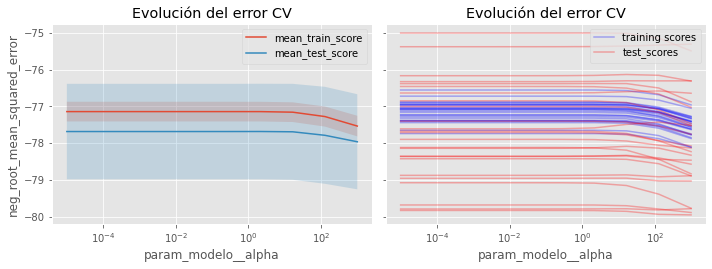

In [103]:
# Gráfico resultados validación cruzada para cada hiperparámetro
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.84), sharey=True)

# Gráfico 1
# ------------------------------------------------------------------------------
resultados.plot('param_modelo__alpha', 'mean_train_score', ax=axes[0])
resultados.plot('param_modelo__alpha', 'mean_test_score', ax=axes[0])
axes[0].fill_between(resultados.param_modelo__alpha.astype(np.float),
                resultados['mean_train_score'] + resultados['std_train_score'],
                resultados['mean_train_score'] - resultados['std_train_score'],
                alpha=0.2)
axes[0].fill_between(resultados.param_modelo__alpha.astype(np.float),
                resultados['mean_test_score'] + resultados['std_test_score'],
                resultados['mean_test_score'] - resultados['std_test_score'],
                alpha=0.2)
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_title('Evolución del error CV')
axes[0].set_ylabel('neg_root_mean_squared_error');

# Gráfico 2
# ------------------------------------------------------------------------------
numero_splits = grid.n_splits_

resultados.plot(
    x     = 'param_modelo__alpha',
    y     = [f'split{i}_train_score' for i in range(numero_splits)],
    alpha = 0.3,
    c     = 'blue', 
    ax    = axes[1]
)

resultados.plot(
    x     = 'param_modelo__alpha',
    y     = [f'split{i}_test_score' for i in range(numero_splits)],
    alpha = 0.3,
    c     = 'red', 
    ax    = axes[1]
)

axes[1].legend(
    (axes[1].get_children()[0], axes[1].get_children()[numero_splits]),
    ('training scores', 'test_scores')
)
axes[1].set_xscale('log')
axes[1].set_title('Evolución del error CV')
axes[1].set_ylabel('neg_root_mean_squared_error');

fig.tight_layout()

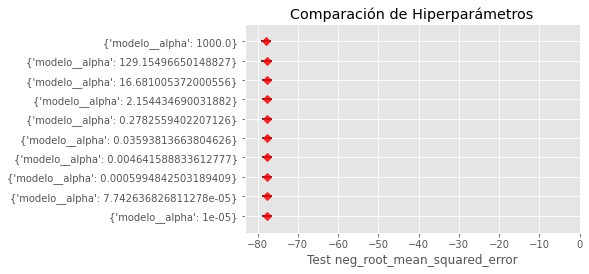

In [104]:
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.barh(
    [str(d) for d in resultados['params']],
    resultados['mean_test_score'],
    xerr=resultados['std_test_score'],
    align='center',
    alpha=0
)
ax.plot(
    resultados['mean_test_score'],
    [str(d) for d in resultados['params']],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Comparación de Hiperparámetros')
ax.set_xlabel('Test neg_root_mean_squared_error');

## Random grid search

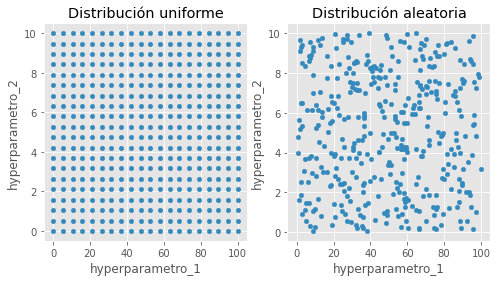

In [22]:
from itertools import product
import random

fig, axs = plt.subplots(nrows = 1, ncols = 2,figsize=(8, 4),
                        sharex = True, sharey = False)

# GRID EXHAUSTIVO
# ==============================================================================
hyperparametro_1 = np.linspace(start = 0, stop = 100, num=20)
hyperparametro_2 = np.linspace(start = 0, stop = 10, num=20)

# Lista con todas las combinaciones
combinaciones = [list(x) for x in product(hyperparametro_1, hyperparametro_2)]
combinaciones = pd.DataFrame.from_records(
                    combinaciones,
                    columns=['hyperparametro_1', 'hyperparametro_2']
                )

combinaciones.plot(
    x    = 'hyperparametro_1',
    y    = 'hyperparametro_2',
    kind = 'scatter',
    ax   = axs[0]
)
axs[0].set_title('Distribución uniforme')

# RANDOM GRID
# ==============================================================================
hyperparametro_1 = np.random.uniform(low = 0, high = 100, size  = 400)
hyperparametro_2 = np.random.uniform(low = 0, high = 10, size  = 400)

combinaciones = pd.DataFrame(
                    {
                    'hyperparametro_1': hyperparametro_1,
                    'hyperparametro_2': hyperparametro_2,
                    }
                )
combinaciones.plot(
    x    = 'hyperparametro_1',
    y    = 'hyperparametro_2',
    kind = 'scatter',
    ax   = axs[1]
)
axs[1].set_title('Distribución aleatoria');

In [106]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

# Espacio de búsqueda de cada hiperparámetro
# ==============================================================================
param_distributions = {'modelo__alpha': np.logspace(-5, 3, 100)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 50,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 5), 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
11,1.78865,-77.62089,0.767568,-77.145762,0.177017


## Optimización bayesiana

In [20]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

espacio_busqueda  = [Real(1e-6, 1e+3, "log-uniform", name='modelo__alpha')]

@use_named_args(espacio_busqueda)
def objective(**params):
    pipe.set_params(**params)
    return -np.mean(cross_val_score(pipe, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_root_mean_squared_error"))

resultados_opt = gp_minimize(
                    func         = objective,
                    dimensions   = espacio_busqueda,
                    n_calls      = 50,
                    random_state = 0
                )

print(f"Mejor score validación: {resultados_opt.fun}")
print(f"Mejores hiperparámetros: {list(zip([x.name for x in espacio_busqueda], resultados_opt.x))}")

Mejor score validación: 77.58163139329784
Mejores hiperparámetros: [('modelo__alpha', 1.6896495676731587)]


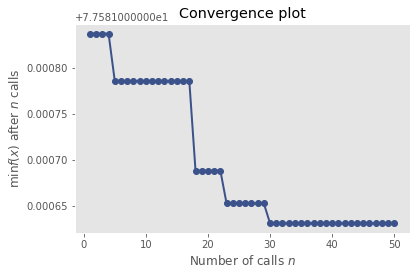

In [21]:
# Evolución de la optimización
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3.84))
plot_convergence(resultados_opt, ax = ax);

## Tuning del preprocesado

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_selector

# Pipe: preprocesado + modelo
# ==============================================================================
# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )


preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, make_column_selector(dtype_include=np.number)),
                        ('cat', categorical_transformer, make_column_selector(dtype_include='object'))
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline(
        [('preprocessing', preprocessor),
        ('interactions', PolynomialFeatures(degree=2)),
        ('modelo', Ridge())])

# Grid de hiperparámetros
# ==============================================================================
param_grid = {'interactions': [PolynomialFeatures(degree=2), 'passthrough'],
              'modelo__alpha': np.logspace(-5, 3, 10)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = pipe,
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 5), 
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)


,param_interactions,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
17,passthrough,16.681005,-77.611749,0.970204,-77.142113,0.184596


# Algoritmos

En los siguientes apartados se entrenan diferentes modelos de machine learning con el objetivo de compararlos e identificar el que mejor resultado obtiene prediciendo el nps100.

## K-Nearest Neighbor (kNN)
K-Nearest Neighbor es uno de los algoritmos de machine learning más simples. Su funcionamiento es el siguiente: para predecir una observación se identifican las K observaciones del conjunto de entrenamiento que más se asemejan a ella (en base a sus predictores) y se emplea como valor predicho el promedio de la variable respuesta en dichas observaciones. Dada su sencillez, suele dar peores resultados que otros algoritmos, pero es un buen referente como baseline.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', KNeighborsRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {'modelo__n_neighbors': np.linspace(1, 100, 500, dtype=int)}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3), 
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

In [34]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_knn = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print(f"El error (rmse) de test es: {rmse_knn}")


El error (rmse) de test es: 74.96576143585825


## Regresión lineal (Ridge y Lasso)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.linear_model import Ridge

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', Ridge())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {'modelo__alpha': np.logspace(-5, 5, 500)}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3), 
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

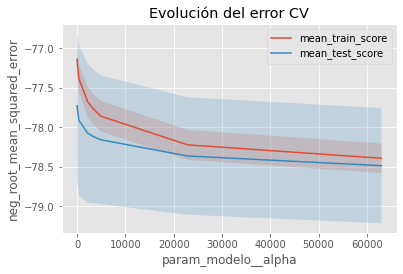

In [22]:
# Gráfico resultados validación cruzada para cada hiperparámetro
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3.84))
hiperparametro = 'param_modelo__alpha'
resultados = resultados.sort_values(hiperparametro, ascending = False)
metrica    = grid.scoring

resultados.plot(hiperparametro, 'mean_train_score', ax=ax)
resultados.plot(hiperparametro, 'mean_test_score', ax=ax)
ax.fill_between(resultados[hiperparametro].astype(np.int),
                resultados['mean_train_score'] + resultados['std_train_score'],
                resultados['mean_train_score'] - resultados['std_train_score'],
                alpha=0.2)
ax.fill_between(resultados[hiperparametro].astype(np.int),
                resultados['mean_test_score'] + resultados['std_test_score'],
                resultados['mean_test_score'] - resultados['std_test_score'],
                alpha=0.2)
ax.legend()
ax.set_title('Evolución del error CV')
ax.set_ylabel(metrica);

In [24]:
from sklearn.metrics import mean_squared_error
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_lm = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_lm}")

El error (rmse) de test es: 76.00153282795597


## Random Forest

In [36]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', RandomForestRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [50, 100, 1000, 2000],
    'modelo__max_features': ["auto", 3, 5, 7],
    'modelo__max_depth'   : [None, 3, 5, 10, 20]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__n_estimators,param_modelo__max_features,param_modelo__max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
16,1000,7,10,-76.627739,0.926594,-68.437545,0.266518


In [37]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_rf = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_rf}")

El error (rmse) de test es: 75.10480921170299


## Gradient Boosting Trees

In [28]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', GradientBoostingRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [50, 100, 1000, 2000],
    'modelo__max_features': ["auto", 3, 5, 7],
    'modelo__max_depth'   : [None, 3, 5, 10, 20],
    'modelo__subsample'   : [0.5,0.7, 1]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__subsample,param_modelo__n_estimators,param_modelo__max_features,param_modelo__max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
15,1,100,auto,3,-76.537778,0.741658,-73.580806,0.157601


In [29]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_gbm = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_gbm}")

El error (rmse) de test es: 74.96576143585825


## Stacking

In [48]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

# Pipeline: preprocesado + modelos para el stacking
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y los modelos creando varios pipeline.
pipe_ridge = Pipeline([('preprocessing', preprocessor),
                     ('ridge', Ridge(alpha=3.4))])

pipe_rf = Pipeline([('preprocessing', preprocessor),
                     ('random_forest', RandomForestRegressor(
                                         n_estimators = 1000,
                                         max_features = 7,
                                         max_depth    = 20
                                        )
                     )])

In [53]:
# Definición y entrenamiento del StackingRegressor
# ==============================================================================
estimators = [('ridge', pipe_ridge),
              ('random_forest', pipe_rf)]

stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())
# Se asigna el resultado a _ para que no se imprima por pantalla
_ = stacking_regressor.fit(X = X_train, y = y_train)

In [54]:
# Error de test del stacking
# ==============================================================================
modelo_final = stacking_regressor
predicciones = modelo_final.predict(X = X_test)
rmse_stacking = mean_squared_error(
                    y_true  = y_test,
                    y_pred  = predicciones,
                    squared = False
                  )
print(f"El error (rmse) de test es: {rmse_stacking}")

El error (rmse) de test es: 74.72550182527843


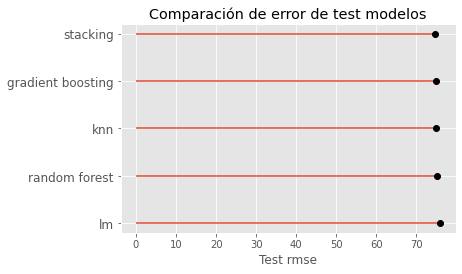

In [38]:
error_modelos = pd.DataFrame({
                        'modelo': ['knn', 'lm', 'random forest', 'gradient boosting',
                                   'stacking'],
                        'rmse': [rmse_knn, rmse_lm, rmse_rf, rmse_gbm, rmse_stacking]
                     })
error_modelos = error_modelos.sort_values('rmse', ascending=False)

fig, ax = plt.subplots(figsize=(6, 3.84))
ax.hlines(error_modelos.modelo, xmin=0, xmax=error_modelos.rmse)
ax.plot(error_modelos.rmse, error_modelos.modelo, "o", color='black')
ax.tick_params(axis='y', which='major', labelsize=12)
ax.set_title('Comparación de error de test modelos'),
ax.set_xlabel('Test rmse');

In [ ]:
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
y_testa=y_test>60
prediccionesa=predicciones>60
print(classification_report(y_testa,prediccionesa))